In [1]:
cd '/opt/ml/'

/opt/ml


In [2]:
# !pip install -r requirements.txt
# !pip install efficientnet_pytorch
!pip install tqdm 
!pip install git+https://github.com/albumentations-team/albumentations
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-2ycf9gmc
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-2ycf9gmc
  Created wheel for albumentations: filename=albumentations-0.5.2-py3-none-any.whl size=88322 sha256=e0212d951c8575d7906bfd42c6f516561dc43aef6017adb5bd6d407468d0594b
  Stored in directory: /tmp/pip-ephem-wheel-cache-u70hvdqq/wheels/3a/25/ed/ec3b518e7a332d7f0a3bb37c280e1b784cf2f79b94b3c7d00b
Successfully built albumentations


In [3]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from torchvision import transforms 
import time, os, sys, copy, random 
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import train_test_split
from glob import glob 
from torch.utils.data import Dataset,DataLoader 
import cv2
import albumentations as A

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [23]:
train_df=pd.read_csv('./input/data/train/train.csv')
temp=pd.DataFrame(np.digitize(train_df.iloc[:,3].values,[29,59,100],[0,1,2]),columns=['Age'])
train_df=pd.concat([train_df,temp],axis=1)
train_df=train_df.drop(['age'],axis=1)
train_df['gender']=train_df['gender'].map({'female':0,'male':1})
train_df=train_df.drop(['race'],axis=1)
train_df.head()

,id,gender,path,Age
0,000001,0,000001_female_Asian_45,1
1,000002,0,000002_female_Asian_52,1
2,000004,1,000004_male_Asian_54,1
3,000005,0,000005_female_Asian_58,1
4,000006,0,000006_female_Asian_59,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2700 entries, 0 to 2699
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2700 non-null   object
 1   gender  2700 non-null   int64 
 2   path    2700 non-null   object
 3   Age     2700 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 84.5+ KB


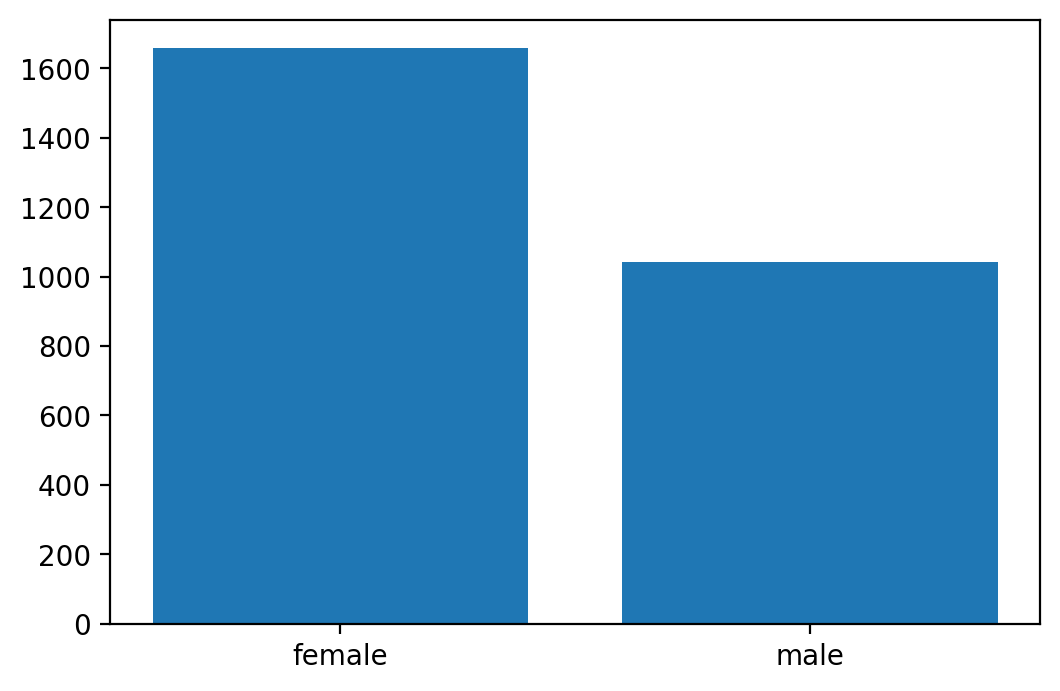

1281
1142
277


In [20]:
plt.figure(dpi=200)
plt.bar(['female','male'],[train_df['gender'][train_df['gender']==0].count(),train_df['gender'][train_df['gender']==1].count()])
plt.show()
print(train_df['Age'][train_df['Age']==0].count())
print(train_df['Age'][train_df['Age']==1].count())
print(train_df['Age'][train_df['Age']==2].count())

<BarContainer object of 3 artists>

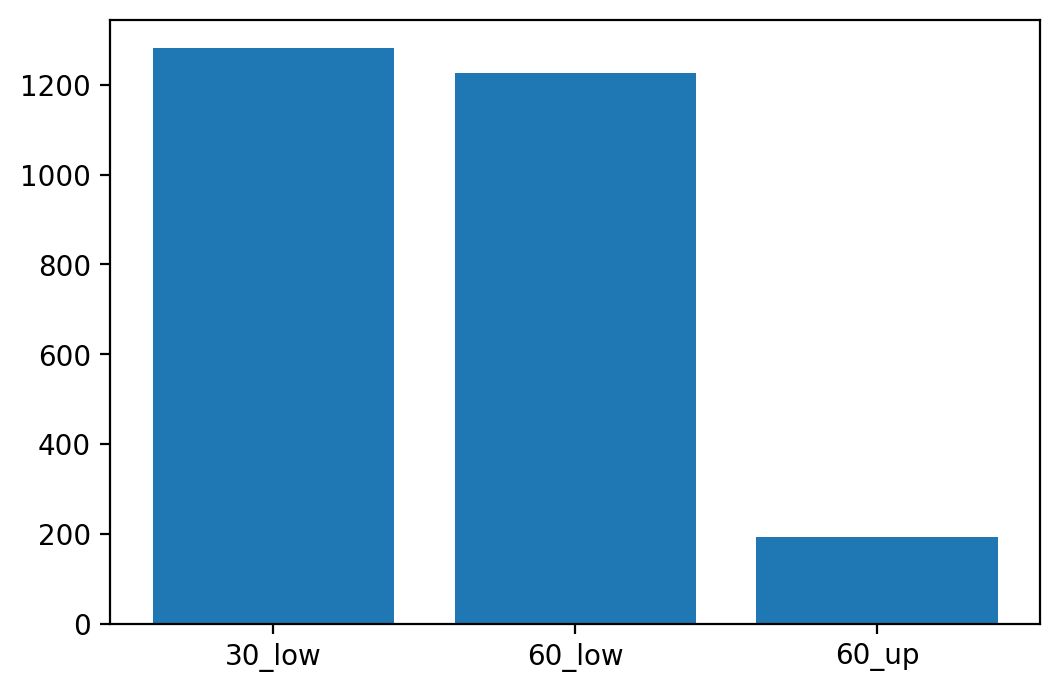

In [24]:
plt.figure(dpi=200)
plt.bar(['30_low','60_low','60_up'],[train_df['Age'][train_df['Age']==0].count(),train_df['Age'][train_df['Age']==1].count(),train_df['Age'][train_df['Age']==2].count(),])

In [8]:
!pwd

/opt/ml


In [9]:
def prepare_data(data_path):
    same_name=set()
    data={'path':[],'label':[]}
    cnt=0
    for label in os.listdir(data_path):
        label_temp=None
        
        if label[:2]=='._': continue
        sub=os.path.join(data_path,label)
        cnt+=1
        
        for img in os.listdir(sub):
            if img[0]=='.':continue
            if img.find('normal')!=-1:
                label_temp=0
            elif img.find('incorrect')!=-1:
                label_temp=2
            else: label_temp=1
            data['path'].append(os.path.join(sub,img))
            data['label'].append(label_temp)
    return pd.DataFrame(data),cnt

label_df,cnt=prepare_data('./input/data/train/images')
        
            
        

In [10]:
def normal_weights(data):
    normed_weights=torch.FloatTensor([1-(x/sum(data))for x in data]).to(device)
    return normed_weights
weighted_mask=normal_weights([1,5,1])
weighted_age=normal_weights([1281,1142,277])
weighted_gender=normal_weights([1658,1042])
print(weighted_mask)
print(weighted_age)
print(weighted_gender)

tensor([0.8571, 0.2857, 0.8571], device='cuda:0')
tensor([0.5256, 0.5770, 0.8974], device='cuda:0')
tensor([0.3859, 0.6141], device='cuda:0')


In [11]:
print(label_df.info())
label_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18900 non-null  object
 1   label   18900 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 295.4+ KB
None


,path,label
0,./input/data/train/images/000523_female_Asian_...,1
1,./input/data/train/images/000523_female_Asian_...,0
2,./input/data/train/images/000523_female_Asian_...,1
3,./input/data/train/images/000523_female_Asian_...,1
4,./input/data/train/images/000523_female_Asian_...,2


In [12]:
temp={'gender':[], 'Age':[]}
for idx,i in enumerate(label_df.iloc[:,0].values):
    
    classes=i.split('/')[-2]
    for row in train_df.values:
        if classes==row[2]:
            temp['gender'].append(row[1])
            temp['Age'].append(row[3])
labels=pd.DataFrame(temp)
labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18900 entries, 0 to 18899
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   gender  18900 non-null  int64
 1   Age     18900 non-null  int64
dtypes: int64(2)
memory usage: 295.4 KB


In [13]:
label_df=pd.concat([label_df,labels['Age'],labels['gender']],axis=1)
label_df.head()


,path,label,Age,gender
0,./input/data/train/images/000523_female_Asian_...,1,1,0
1,./input/data/train/images/000523_female_Asian_...,0,1,0
2,./input/data/train/images/000523_female_Asian_...,1,1,0
3,./input/data/train/images/000523_female_Asian_...,1,1,0
4,./input/data/train/images/000523_female_Asian_...,2,1,0


In [14]:
label_df.to_csv('./not_working.csv',index=False)

In [15]:
####################################### crop된 새로운 이미지!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
import re
for idx,i in enumerate(label_df.values):
    temp=i[0]
    temp=re.sub('images','new_img',temp)
    label_df.iloc[idx,0]=temp

label_df.head()

,path,label,Age,gender
0,./input/data/train/new_img/000523_female_Asian...,1,1,0
1,./input/data/train/new_img/000523_female_Asian...,0,1,0
2,./input/data/train/new_img/000523_female_Asian...,1,1,0
3,./input/data/train/new_img/000523_female_Asian...,1,1,0
4,./input/data/train/new_img/000523_female_Asian...,2,1,0


In [16]:
class PstageDataset_mask(Dataset):
    def __init__(self,data,transforms=None):
        self.data=data
        self.transforms=transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path=self.data.iloc[index,0]
        label=int(self.data.iloc[index,1])
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image=self.transforms(image=image)['image']
        image=image.transpose((2,0,1))
        sample={'image':image, 'label':label}
        return sample


class PstageDataset_Age(Dataset):
    def __init__(self,data,transforms=None):
        self.data=data
        self.transforms=transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path=self.data.iloc[index,0]
        label=int(self.data.iloc[index,2])
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image=self.transforms(image=image)['image']
        image=image.transpose((2,0,1))
        sample={'image':image, 'label':label}
        return sample
    
class PstageDataset_gender(Dataset):
    def __init__(self,data,transforms=None):
        self.data=data
        self.transforms=transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path=self.data.iloc[index,0]
        label=int(self.data.iloc[index,3])
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image=self.transforms(image=image)['image']
        image=image.transpose((2,0,1))
        sample={'image':image, 'label':label}
        return sample
    

train_tfms_mask = A.Compose([
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.GaussianBlur(p=0.5),
        A.ISONoise(p=0.5),
    ],p=0.5),
    A.OneOf([
        A.IAAPerspective(p=0.6)
    ],p=0.5),
    
    A.Rotate(limit=20, p=0.5, border_mode=1),
    A.ColorJitter(p=0.5),
    A.OneOf([
        A.RandomBrightness(p=0.5),
        A.RandomContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.CLAHE(p=0.5)
    ],p=0.5),
    A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
])
])
train_tfms = A.Compose([
     A.OneOf([
        A.RandomGridShuffle(grid=(2,2),p=1.0),
        A.RandomGridShuffle(grid=(4,2),p=1.0),
    ],p=0.6),
        A.IAAPerspective(p=0.4),
    A.OneOf([
        A.GaussNoise(p=0.5),
        A.ISONoise(p=0.5),
    ],p=0.5),
    A.Rotate(limit=20, p=0.5, border_mode=1),
    A.OneOf([
        A.RandomBrightness(p=0.5),
        A.RandomGamma(p=0.5),
        A.CLAHE(p=0.5)
    ],p=0.5),
    A.Compose([
    A.Resize(224, 224),
    A.Normalize(),
])
])
valid_tfms = A.Compose([
                    A.Resize(224,224),
                    A.Normalize(),
])
def make_seed( seed):
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)  # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(seed)
  random.seed(seed)
seed=777
make_seed(777)


/opt/conda/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:334: FutureWarning: IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1701: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1727: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [17]:
### 아크페이스 loss
class ArcFace(nn.Module):
    def __init__(self, s=64.0, m=0.5):
        super(ArcFace, self).__init__()
        self.s = s
        self.m = m

    def forward(self, cosine: torch.Tensor, label):
        index = torch.where(label != -1)[0]
        m_hot = torch.zeros(index.size()[0], cosine.size()[1], device=cosine.device)
        m_hot.scatter_(1, label[index, None], self.m)
        cosine.acos_()
        cosine[index] += m_hot
        cosine.cos_().mul_(self.s)
        return cosine

In [18]:
label_df.dtypes

path      object
label      int64
Age        int64
gender     int64
dtype: object

In [ ]:
from sklearn.model_selection import KFold

def train(num_epochs=25,batch_size=16):
    kfold=KFold(n_splits=4, shuffle=True)
    best_loss_mask,best_loss_age,best_loss_gender=100,100,100
    criterion = nn.CrossEntropyLoss(weight=weighted_mask).to(device)
    model_mask=EfficientNet.from_pretrained('efficientnet-b5',num_classes=3).to(device)
    optimizer_mask= torch.optim.Adam(model_mask.parameters(),lr=3e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_mask,mode='min',factor=0.5,patience=3)

    
    for fold,(train_ids,valid_ids) in enumerate(kfold.split(label_df)):
        if fold==1:
            return model.state_dict()
        train_mask_data=PstageDataset_mask(label_df.iloc[train_ids],transforms=train_tfms_mask)
        valid_mask_data=PstageDataset_mask(label_df.iloc[valid_ids],transforms=valid_tfms)
        train_dl_mask=DataLoader(train_mask_data,batch_size=batch_size,shuffle=True,num_workers=6)
        valid_dl_mask=DataLoader(valid_mask_data,batch_size=batch_size,shuffle=False,num_workers=6)
        train_loss_mask,valid_loss_mask,train_acc_mask,valid_acc_mask=[],[],[],[]
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            for phase in ['train','valid']:
                if phase=='train':
                    model_mask.train()
                if phase=='valid':
                    model_mask.eval()
                    
                running_loss_mask,running_loss_age,running_loss_gender,running_corrects_mask,running_corrects_age,running_corrects_gender,num_cnt=0.0,0.0,0.0,0.0,0.0,0.0,0.0
                
                if phase=='train':
                    for sample_mask in tqdm.tqdm(train_dl_mask):
                        inputs_mask,label_mask=sample_mask['image'],sample_mask['label']
                        inputs_mask=inputs_mask.to(device)
                        label_mask=label_mask.to(device)
                        optimizer_mask.zero_grad()
                        
                        with torch.set_grad_enabled(phase=='train'):
                            outputs_mask=model_mask(inputs_mask)
                            _, preds_mask=torch.max(outputs_mask,1)
                            loss_mask=criterion(outputs_mask,label_mask)
                            loss_mask.backward()
                            optimizer_mask.step() 
                if phase=='valid':
                    
                    for sample_mask in tqdm.tqdm(valid_dl_mask):
                        inputs_mask,label_mask=sample_mask['image'],sample_mask['label']
                        inputs_mask=inputs_mask.to(device)
                        label_mask=label_mask.to(device)
                        optimizer_mask.zero_grad()
                        with torch.no_grad():
                            outputs_mask=model_mask(inputs_mask)
                            _, preds_mask=torch.max(outputs_mask,1)
                            loss_mask=criterion(outputs_mask,label_mask)
                 
                running_loss_mask+=loss_mask.item()*batch_size
                if phase=='train':
                    scheduler.step(running_loss_mask)
                running_corrects_mask+=torch.sum(preds_mask==label_mask.data)
                num_cnt+=len(label_mask)
                epoch_loss_mask=float(running_loss_mask)
                epoch_acc_mask=float((running_corrects_mask/num_cnt).cpu()*100)
                
                if phase=='train':
                    train_loss_mask.append(epoch_loss_mask)
                    train_acc_mask.append(epoch_acc_mask)
                else :
                    valid_loss_mask.append(epoch_loss_mask)
                    valid_acc_mask.append(epoch_acc_mask)
                print('{} Loss_mask: {:.4f} Acc_mask: {:.2f} '.format(phase, epoch_loss_mask, epoch_acc_mask))
                
                if phase=='valid' and epoch_loss_mask<best_loss_mask:
                    best_loss_mask=epoch_loss_mask
                    best_model_mask=copy.deepcopy(model_mask.state_dict())
                    torch.save(best_model_mask,'best_model_mask.pth')
                    print('best_mask_model saved')
    return model_mask.state_dict()
import tqdm
model_mask_current=train(num_epochs=15,batch_size=32)

  0%|          | 0/443 [00:00<?, ?it/s]

Loaded pretrained weights for efficientnet-b5
Epoch 0/14
----------


  3%|▎         | 12/443 [00:09<05:22,  1.34it/s]

In [ ]:
import torch.nn.functional as F
from torch.utils.data import RandomSampler
from sklearn.metrics import f1_score 

def train_age(num_epochs=25,batch_size=32):
    kfold=KFold(n_splits=4, shuffle=True)
    best_loss_mask,best_loss_age,best_loss_gender=1e10,1e10,1e10
    best_f1=0
    ###################################

    ################################## loss에  cuda 붙여보기 
    criterion = nn.CrossEntropyLoss(weighted_age).to(device)
    #################################
    model_age=EfficientNet.from_pretrained('efficientnet-b5',num_classes=3).to(device)
    optimizer_age= torch.optim.Adam(model_age.parameters(),lr=3e-4)  
    #optimizer_age=torch.optim.SGD(model_age.parameters(),lr=1e-3,weight_decay=1e-4,momentum=0.9)
    ################# 스칼라 값 추가 해보기 
    scaler =torch.cuda.amp.GradScaler()
    ###################
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_age,mode='min',factor=0.2,patience=3)
#     for fold,(train_ids,valid_ids) in enumerate(kfold.split(label_df)):
#         if fold==1:
#             return model_age.state_dict()
    train_age_data=PstageDataset_Age(label_df.iloc[:int(len(label_df)*0.9):,:],transforms=train_tfms)
    valid_age_data=PstageDataset_Age(label_df.iloc[int(len(label_df)*0.9):,:],transforms=valid_tfms)
    train_age_sampler=RandomSampler(train_age_data)
    valid_age_sampler=RandomSampler(valid_age_data)
    train_dl_age=DataLoader(train_age_data,batch_size=batch_size,shuffle=False,sampler=train_age_sampler,num_workers=6)
    valid_dl_age=DataLoader(valid_age_data,batch_size=batch_size,shuffle=False,sampler=valid_age_sampler,num_workers=6)
    train_loss_age,valid_loss_age,train_acc_age,valid_acc_age=[],[],[],[]
    train_f1_score,valid_f1_score=[],[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        f1_sc=0
        for phase in ['train','valid']:
            if phase=='train':

                model_age.train()

            if phase=='valid':

                model_age.eval()  
            f1, running_loss_mask,running_loss_age,running_loss_gender,running_corrects_mask,running_corrects_age,running_corrects_gender,num_cnt=0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

            if phase=='train':
                for sample_age in tqdm.tqdm(train_dl_age):
                    with torch.cuda.amp.autocast(enabled=True):
                        inputs_mask,label_age=sample_age['image'],sample_age['label']
                        inputs_mask=inputs_mask.to(device)
                        label_age=label_age.to(device)
                    with torch.set_grad_enabled(phase=='train'):

                        outputs_age=model_age(inputs_mask)
                        _,preds_age=torch.max(outputs_age,1)
                        loss_age=criterion(outputs_age,label_age)
                        scaler.scale(loss_age).backward()
                        scaler.step(optimizer_age)
                        scaler.update()
                        #loss_age.backward()
                        #optimizer_age.step()
                        optimizer_age.zero_grad()
                        f1_sc+=f1_score(label_age.detach().cpu(),preds_age.detach().cpu(),average='macro')


            if phase=='valid':

                for sample_age in tqdm.tqdm(valid_dl_age):
                    inputs_mask,label_age=sample_age['image'],sample_age['label']
                    inputs_mask=inputs_mask.to(device)
                    label_age=label_age.to(device)
                    optimizer_age.zero_grad()
                    with torch.no_grad():
                        outputs_age=model_age(inputs_mask)
                        _,preds_age=torch.max(outputs_age,1)
                        loss_age=criterion(outputs_age,label_age)
                        f1_sc+=f1_score(label_age.detach().cpu(),preds_age.detach().cpu(),average='macro')

            running_loss_age+=loss_age.item()*batch_size
            f1=f1_sc
            if phase=='train':
                scheduler.step(f1)
            running_corrects_age+=torch.sum(preds_age==label_age.data)
            num_cnt+=len(label_age)
            epoch_loss_age=float(running_loss_age)
            epoch_acc_age=float((running_corrects_age/num_cnt).cpu()*100)

            print('{}Loss_age:{:.4f} Acc_age{:.2f} F1_score{:.4f}'.format(phase, epoch_loss_age,epoch_acc_age,f1/num_cnt))


            #if phase=='valid' and epoch_loss_age<=best_loss_age:
            if phase=='valid' and epoch_loss_age<best_loss_age:
                best_loss_age=epoch_loss_age
                best_model_age=copy.deepcopy(model_age.state_dict())
                torch.save(best_model_age,'best_model_age.pth')
                print('best_age_model saved')
    return model_age.state_dict()
model_age_current=train_age(batch_size=15,num_epochs=10)

In [ ]:
from torch.utils.data import RandomSampler

def train_gender(num_epochs=30,batch_size=16):
    kfold=KFold(n_splits=4, shuffle=True)
    best_loss_mask,best_loss_age,best_loss_gender=100,100,100
    best_f1_score=0
    criterion = nn.CrossEntropyLoss(weighted_gender)
    model_gender=EfficientNet.from_pretrained('efficientnet-b5',num_classes=2).to(device)
    optimizer_gender= torch.optim.Adam(model_gender.parameters(),lr=3e-4)
    #optimizer_gender=torch.optim.SGD(model_gender.parameters(),lr=5e-3,weight_decay=1e-4,momentum=0.9)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer_gender,mode='min',factor=0.2,patience=3)
#     for fold,(train_ids,valid_ids) in enumerate():
#         if fold==1:
#             return model_gender.state_dict()
    train_gender_data=PstageDataset_gender(label_df.iloc[:int(len(label_df)*0.9),:],transforms=train_tfms)
    valid_gender_data=PstageDataset_gender(label_df.iloc[int(len(label_df)*0.9):,:],transforms=valid_tfms)
    train_gender_sampler=RandomSampler(train_gender_data)
    valid_gender_sampler=RandomSampler(valid_gender_data)
    train_dl_gender=DataLoader(train_gender_data,batch_size=batch_size,shuffle=False,sampler=train_gender_sampler,num_workers=4)
    valid_dl_gender=DataLoader(valid_gender_data,batch_size=batch_size,shuffle=False,sampler=valid_gender_sampler,num_workers=4)
    train_loss_gender,valid_loss_gender,train_acc_gender,valid_acc_gender=[],[],[],[]
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train','valid']:
            if phase=='train':
                model_gender.train()
            if phase=='valid':
                model_gender.eval()

            running_loss_mask,running_loss_age,running_loss_gender,running_corrects_mask,running_corrects_age,running_corrects_gender,num_cnt=0.0,0.0,0.0,0.0,0.0,0.0,0.0
            f1=0.0 
            if phase=='train':
                for sample_gender in tqdm.tqdm(train_dl_gender):
                    inputs_mask,label_gender=sample_gender['image'],sample_gender['label']
                    inputs_mask=inputs_mask.to(device)
                    label_gender=label_gender.to(device)

                    optimizer_gender.zero_grad()

                    with torch.set_grad_enabled(phase=='train'):

                        outputs_gender=model_gender(inputs_mask)
                        _,preds_gender=torch.max(outputs_gender,1)

                        loss_gender=criterion(outputs_gender,label_gender)


                        loss_gender.backward()

                        f1_sc=f1_score(label_gender.detach().cpu(),preds_gender.detach().cpu(),average='binary')
                        optimizer_gender.step()
            if phase=='valid':

                for sample_gender in tqdm.tqdm(valid_dl_gender):
                    inputs_mask,label_gender=sample_gender['image'],sample_gender['label']
                    inputs_mask=inputs_mask.to(device)
                    label_gender=label_gender.to(device)

                    optimizer_gender.zero_grad()
                    with torch.no_grad():

                        outputs_gender=model_gender(inputs_mask)

                        _,preds_gender=torch.max(outputs_gender,1)

                        loss_gender=criterion(outputs_gender,label_gender)
                        f1_sc=f1_score(label_gender.detach().cpu(),preds_gender.detach().cpu(),average='binary')


            running_loss_gender+=loss_gender.item()*batch_size
            f1+=f1_sc
            if phase=='train':
                scheduler.step(running_loss_gender)
            running_corrects_gender+=torch.sum(preds_gender==label_gender.data)
            num_cnt+=len(label_gender)
            epoch_loss_gender=float(running_loss_gender)

            epoch_acc_gender=float((running_corrects_gender/num_cnt).cpu()*100)

            print('{}Loss_gender{:.4f} Acc_gender{:.2f} f1_score{:.4f}'.format(phase,epoch_loss_gender,epoch_acc_gender,f1))
#                 if phase=='valid' and epoch_loss_gender<=best_loss_gender:
#                     best_loss_gender=epoch_loss_gender
#                     best_model_gender=copy.deepcopy(model_gender.state_dict())
#                     torch.save(best_model_gender,'best_model_gender.pth')
#                     print('best_gender_model saved')
            if phase=='valid' and epoch_loss_gender<best_loss_gender:
                best_loss_gender=epoch_loss_gender
                best_model_gender=copy.deepcopy(model_gender.state_dict())
                torch.save(best_model_gender,'best_model_gender.pth')
                print('best_gender_model saved')        
    return model_gender.state_dict()
model_gender_current=train_gender(batch_size=32,num_epochs=15)

In [ ]:
classes={
    '110':0,
    '111':1,
    '112':2,
    '100':3,
    '101':4,
    '102':5,
    '210':6,
    '211':7,
    '212':8,
    '200':9,
    '201':10,
    '202':11,
    '010':12,
    '011':13,
    '012':14,
    '000':15,
    '001':16,
    '002':17
}

class PstageDataset_test(Dataset):
    def __init__(self,data,transforms=None):
        self.data=data
        self.transforms=transforms
        self.path='/opt/ml/input/data/eval/new_images'
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path=self.data.iloc[index,0]
        image=cv2.imread(os.path.join(self.path,img_path))
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image=self.transforms(image=image)['image']
        image=image.transpose((2,0,1))
        sample={'image':image}
        return sample
test_data=pd.read_csv('/opt/ml/input/data/eval/info.csv')

submission = pd.read_csv(os.path.join('./input/data/eval', 'info.csv'))
test_data_path='./input/data/eval/new_images'
model_mask=EfficientNet.from_pretrained('efficientnet-b5',num_classes=3).to(device)##################
model_age=EfficientNet.from_pretrained('efficientnet-b5',num_classes=3).to(device)#################
model_gender=EfficientNet.from_pretrained('efficientnet-b5',num_classes=2).to(device)###############
model_mask.load_state_dict(torch.load('./best_model_mask.pth'))
model_age.load_state_dict(torch.load('./best_model_age.pth'))
model_gender.load_state_dict(torch.load('./best_model_gender.pth'))


model_mask.eval()
model_age.eval()
model_gender.eval()
#######################################################################
test_dataset=PstageDataset_test(test_data,transforms=valid_tfms)
test_dl=DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4)
total_answer=list()
for sample in test_dl:
    with torch.no_grad():
        inputs=sample['image'].to(device)
        output_mask=model_mask(inputs)
        output_age=model_age(inputs)
        output_gender=model_gender(inputs)
        _,preds_mask=torch.max(output_mask,1)
        _,preds_age=torch.max(output_age,1)
        _,preds_gender=torch.max(output_gender,1)
        for mask,gender,age in zip(preds_mask,preds_gender,preds_age):
            ans=list()
            ans.append(mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))########################
            data=''.join(ans)   
            total_answer.append(classes[data])
submission['ans']=total_answer
submission.to_csv('./submission_9.csv',index=False)
#######################################################
        
    

In [ ]:

class PstageDataset_valid(Dataset):
    def __init__(self,data,transforms=None):
        self.data=data
        self.transforms=transforms
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
        img_path=self.data.iloc[index,0]
        label_mask=int(self.data.iloc[index,1])
        label_age=int(self.data.iloc[index,2])
        label_gender=int(self.data.iloc[index,3])
        image=cv2.imread(img_path)
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        if self.transforms:
            image=self.transforms(image=image)['image']
        image=image.transpose((2,0,1))
        sample={'image':image, 'label_mask':label_mask,'label_age':label_age,'label_gender':label_gender}
        return sample


valid_test_data=PstageDataset_valid(label_df.iloc[int(len(label_df)*0.8):,:],transforms=valid_tfms)
valid_dl=DataLoader(valid_test_data,batch_size=32,shuffle=False,num_workers=4)
f1=0
f1_sc=0
with torch.no_grad():
    for sample in tqdm.tqdm(valid_dl):
        inputs=sample['image'].to(device)
        output_mask=model_mask(inputs)
        output_age=model_age(inputs)
        output_gender=model_gender(inputs)
        _,preds_mask=torch.max(output_mask,1)
        _,preds_age=torch.max(output_age,1)
        _,preds_gender=torch.max(output_gender,1)
        for mask, gender, age, label_mask, label_gender, label_age in zip(preds_mask,preds_gender,preds_age, sample['label_mask'],sample['label_gender'],sample['label_age']):
            ans=list()
            label=list()
            ans.append(mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            ans.append(age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))########################
            data=''.join(ans)   
            label.append(label_mask.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            label.append(label_gender.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            label.append(label_age.detach().cpu().numpy().astype('|S1').tostring().decode('utf-8'))
            labels=''.join(label)
            ans=np.zeros((18,))
            pred=np.zeros((18,))
            ans[classes[labels]]=1
            pred[classes[data]]=1
            #print(classes[labels],classes[data])
            f1_sc+=f1_score(ans,pred,average='macro')

print(f1_sc/(len(label_df)*0.2))
        
        


In [ ]:
# person_ids = [i for i in range(2700)]
#         kfold = KFold(n_splits=5, shuffle=True, random_state=777)
#         for fold_idx, (trn_idx, val_idx) in enumerate(kfold.split(person_ids), 1):
#             if str(fold_idx) != str(args.s_fold): continue
        
#             torch.cuda.empty_cache()
            
#             t_df['trn'] = t_df['ids'].apply(partial(split_ids,idicies=trn_idx))
#             trn_df = t_df.loc[t_df['trn']==True]
#             val_df = t_df.loc[t_df['trn']==False]